In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [2]:
def word_to_int(df):
    # Red = 1, blue = 0
    df["class"] = 1
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 0
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)



In [3]:
def plot_data(df, ax, suptitle):
    ax.set_title(suptitle)
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_green = df[df["color"] == "blue"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    #legacy
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="blue", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)

    return ax

In [46]:
def plot_results(df, pred_key, ax, suptitle, error_key="None"):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    cmap = red_blue_cmap()
    if error_key == "None":
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                       size=error_key, size_norm = (0.1, 0.3), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    return ax


In [5]:
def predict_grid(model, x1_key, x2_key, device, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth
    #Get softmax score for red
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
    return df

In [6]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
# Read data
trainfile = "train_n_50000_kr7_kb3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kb3_s1_vary_a1_False"
truthfile = "analytical_solution_x1_x2_grid_kr7_kb3_vary_a1_False_nxMC_100_nr1MC_50.csv"
#trainfile = "train_n_50000_kr9_kb3_s1_vary_a1_False"
#valfile = "val_n_5000_kr9_kb3_s1_vary_a1_False"
testfile = "x1_x2_grid"
n_data = [250, 2100, 3600]
#n_data = [10000, 30000, 50000]

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/{truthfile}")

#Convert test to polar
test_data = cartesian_to_polar_df(test_data, "x1", "x2", "r_x", "a_x")

#Choose
ntrain = len(train_data)
x1_key = "x1"
x2_key = "x2"

train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [8]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [9]:
model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
model

SequentialNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
  )
  (first_layer): Linear(in_features=2, out_features=1024, bias=True)
  (last_layer): Linear(in_features=1024, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

100%|██████████| 100/100 [00:00<00:00, 595.94it/s]


Text(0.5, 0.98, 'Number of datapoints: 0')

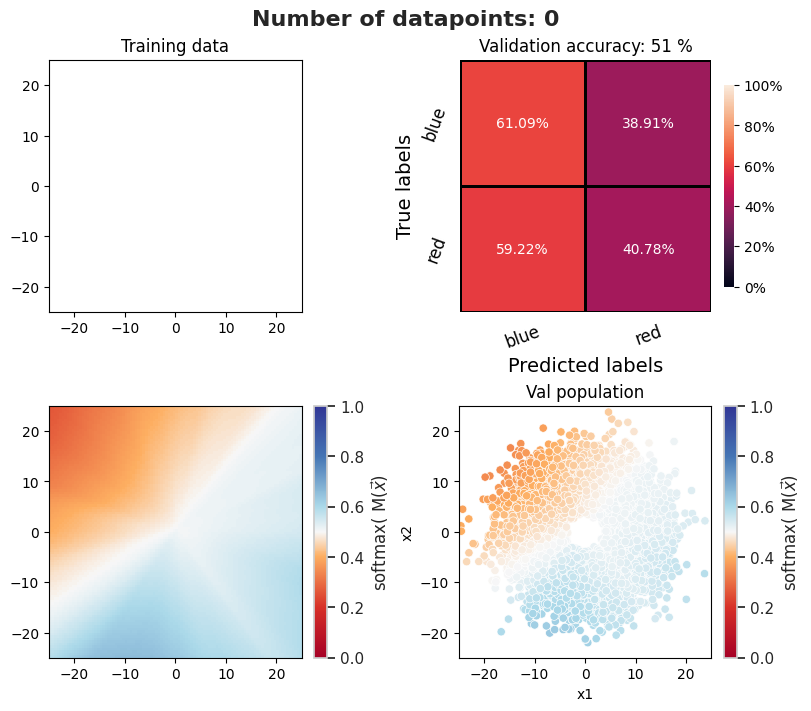

In [11]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)

# Save prediction
#

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data[0:0], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device)
axs[1][0] = plot_grid(grid_df, "Confidence", axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: 0", size=16, fontweight="bold")

100%|██████████| 50/50 [00:00<00:00, 590.03it/s]


<Axes: xlabel='Iteration'>

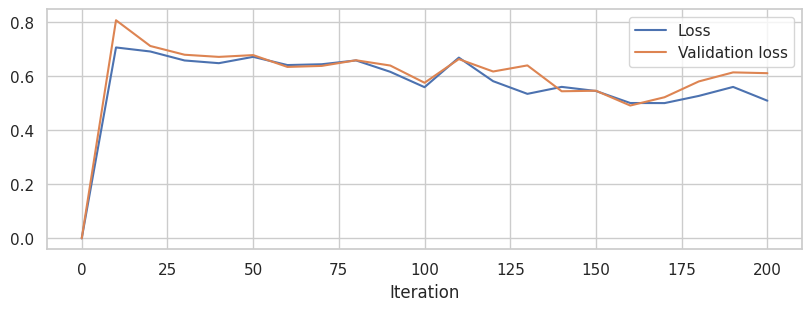

In [12]:
train_dataset = torch.utils.data.TensorDataset(X_train[0:500], Y_train[0:500])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 100, 
                         device = device, optimizer = optimizer)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

In [20]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data[0:500], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device)
axs[1][0] = plot_grid(grid_df, "Confidence", axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")

AssertionError: Please choose batch size so that testdata%size==0.

<Axes: xlabel='Confidence', ylabel='Count'>

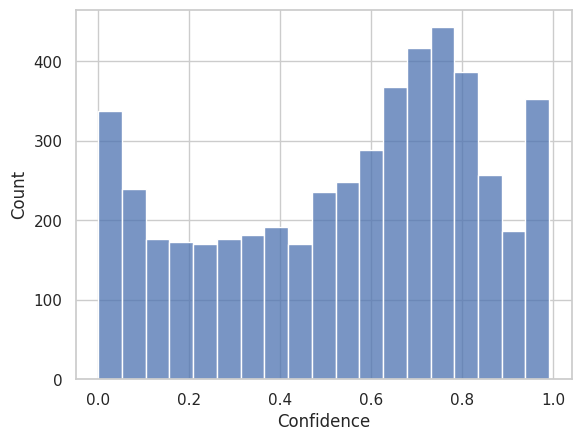

In [14]:
sn.histplot(val_data, x="Confidence")

100%|██████████| 100/100 [00:00<00:00, 590.71it/s]


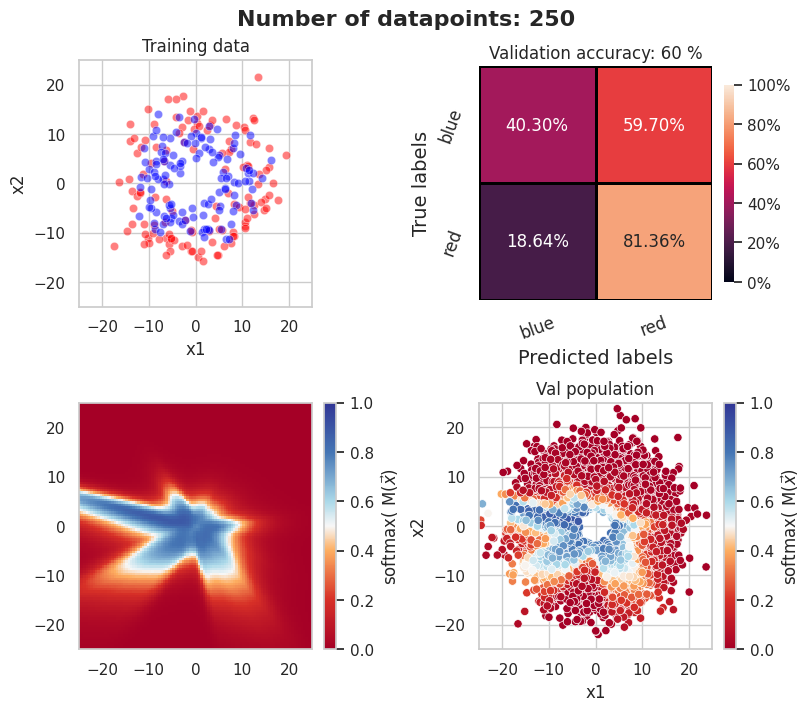

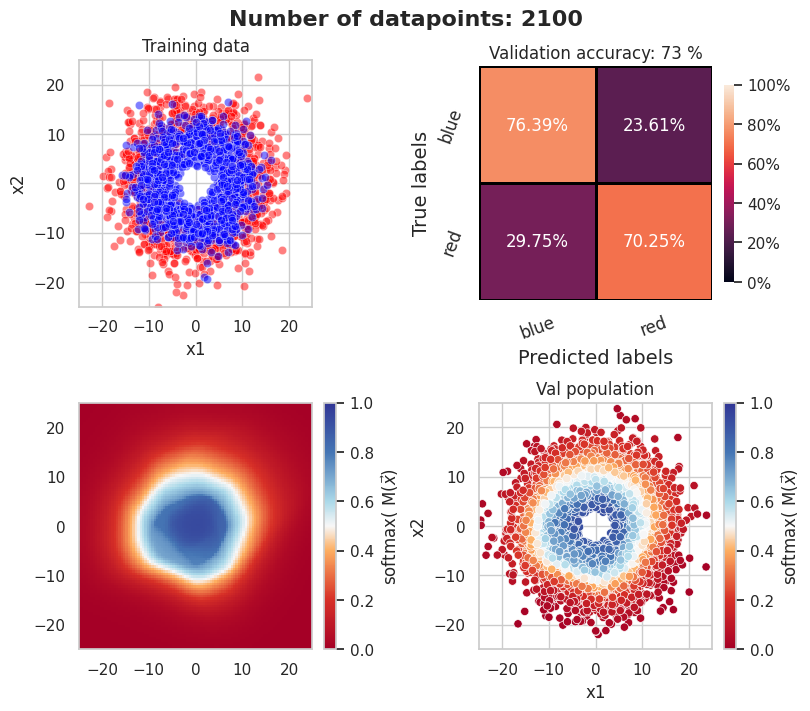

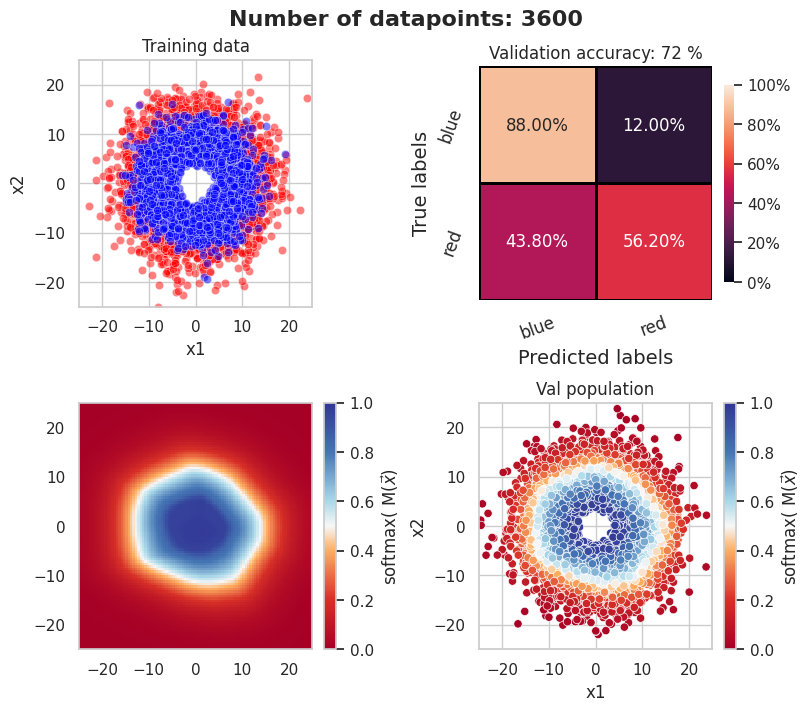

In [21]:

# Plot animation
#n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]

grid_dfs = [0]*len(n_data)

for i in range(len(n_data)):

    # Fresh validation dataframe
    val_data = pd.read_csv(f"../data/{valfile}.csv")
    val_data = word_to_int(val_data)

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

    # Create new model
    model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**9, epochs = 70, 
                            device = device, optimizer = optimizer)
    
    # Predict on new model
    truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data["Prediction"] = preds
    val_data["Truth"] = truth
    #Get softmax score for blue
    val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
    accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
    # Predict for grid
    grid_df = predict_grid(model, x1_key, x2_key, device)
    grid_dfs[i] = grid_df

    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0], "Training data")
    axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
    grid_df = predict_grid(model, x1_key, x2_key, device)
    axs[1][0] = plot_grid(grid_df, "Confidence", axs[1][0])
    axs[1][1] = plot_results(val_data, axs[1][1], "Val population")
    
    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "blue"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")

    # Save plot
    #plt.savefig(f"../../fig/results/DNN/x1_x2_grid_{trainfile}_n_{n_data[i]}")

    # Save prediction
    #val_data.to_csv(f"predictions/{valfile}_predicted_SequentialNet_ndata-{n_data[i]}.csv")
    #grid_df.to_csv(f"predictions/grid_predicted_SequentialNet_ndata-{n_data[i]}.csv")

    # Save model
    #torch.save(model.state_dict(), f"models/{trainfile}_SequentialNet_ndata-{n_data[i]}.pt")

#plt.show()
    

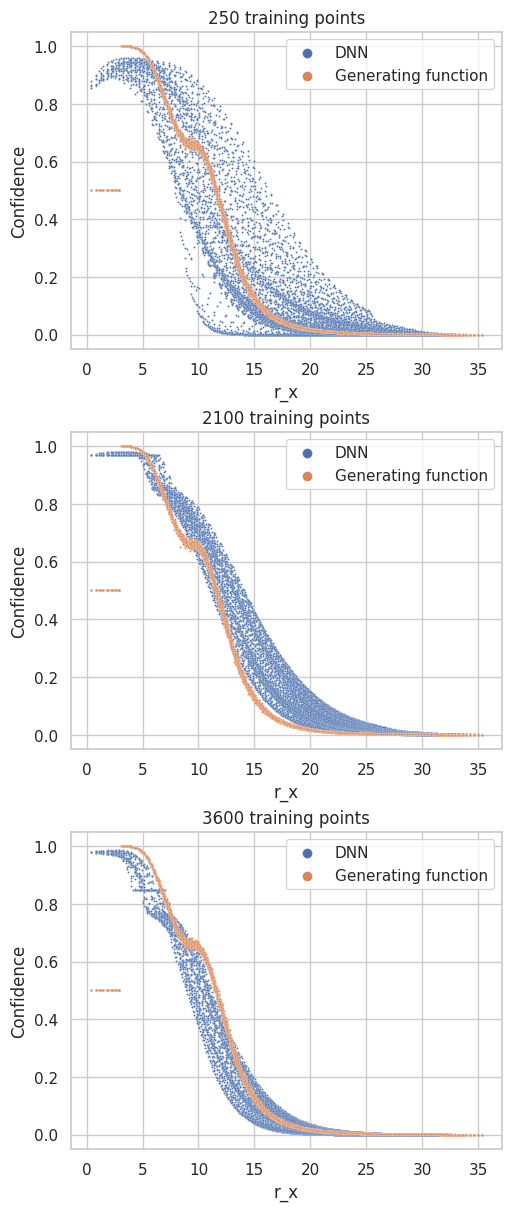

In [16]:
fig, axs = plt.subplots(nrows=len(n_data), ncols=1, figsize= (5, 4*len(n_data)), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=2, ax = axs[i], label ="DNN")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[i], label="Generating function")
    axs[i].set_title(f"{n_data[i]} training points")
    axs[i].legend(markerscale=5)


### Calibration

100%|██████████| 100/100 [00:00<00:00, 573.08it/s]


Text(0.5, 0.98, 'Number of datapoints: 3600')

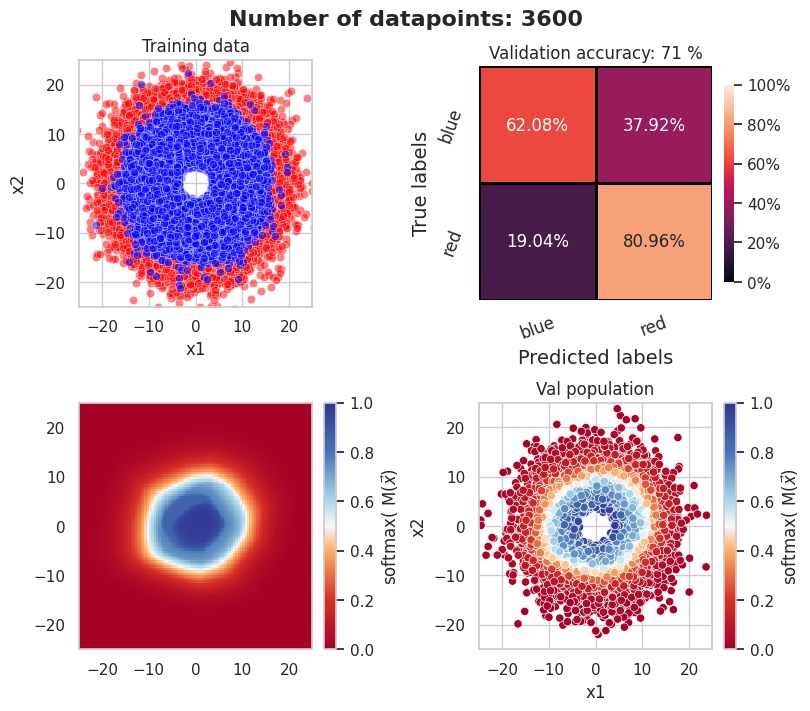

In [17]:

truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_data(train_data, axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[0][1])
axs[1][0] = plot_grid(grid_df, "Confidence", axs[1][0])
axs[1][1] = plot_results(val_data, axs[1][1], "Val population")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")



In [18]:
val_data

,color,x1,x2,a1,a2,r1,r2,r_x,a_x,class,Prediction,Truth,Confidence
0,red,10.165875,-5.737768,5.523416,1.244737,10.361182,3,11.673345,5.769343,1,1,1.0,0.288142
1,red,-8.313172,-10.893792,3.850098,1.267038,12.503745,3,13.703413,4.060549,1,1,1.0,0.110376
2,blue,-0.736831,-7.679405,4.609960,3.124176,10.714041,3,7.714673,4.616733,0,0,0.0,0.652578
3,red,14.840760,-2.497519,6.079409,0.186908,12.091364,3,15.049443,6.116460,1,1,1.0,0.138112
4,blue,5.459488,10.155468,0.898411,0.754240,9.159098,3,11.529941,1.077530,0,1,0.0,0.420404
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,red,7.269948,6.533450,0.452712,2.025342,10.712534,3,9.774360,0.732092,1,0,1.0,0.602877
4996,blue,-5.422939,6.463178,1.929177,1.927284,9.001641,3,8.436880,2.268900,0,0,0.0,0.629129
4997,blue,-9.489099,-0.951813,2.925565,1.726531,9.529833,3,9.536716,3.241564,0,0,0.0,0.593734
4998,red,0.280289,8.096733,1.402873,2.774431,10.829741,3,8.101583,1.536193,1,0,1.0,0.737065


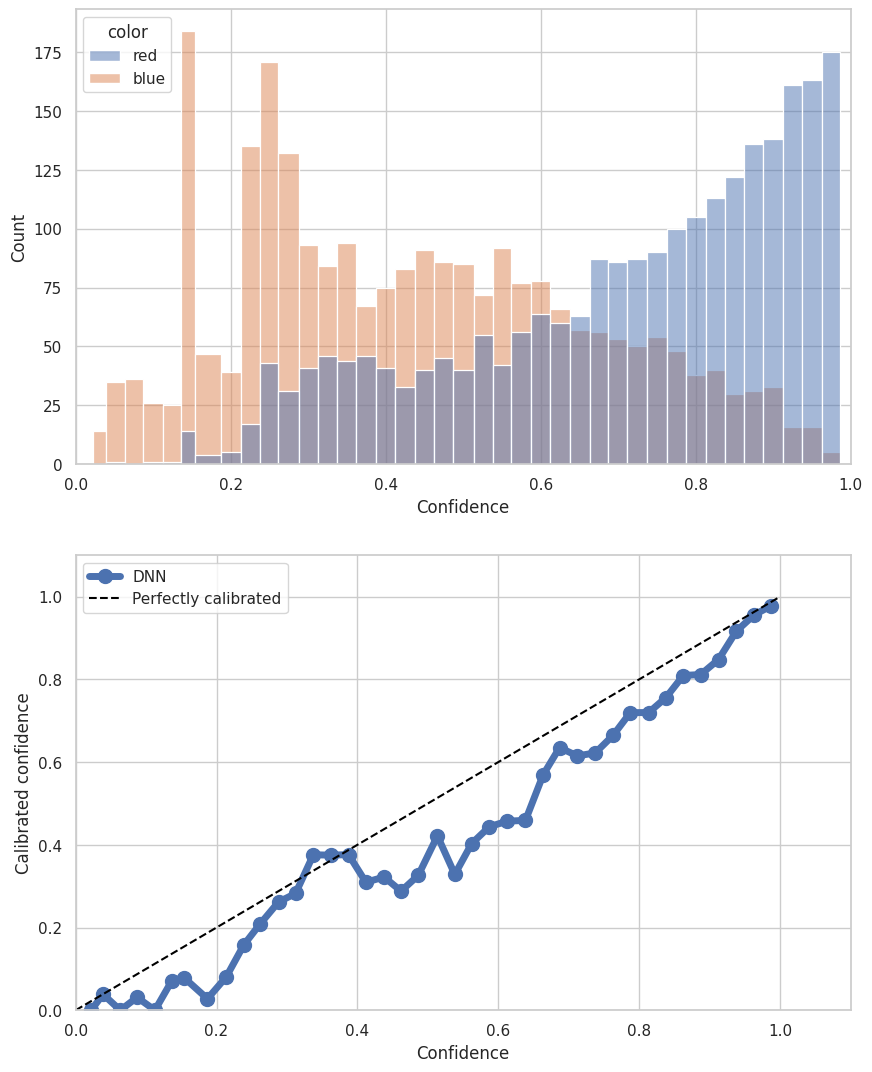

In [19]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
prob_cal, prob_pred = calibration_curve(val_data["Truth"], val_data["Confidence"], n_bins=40, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(val_data, x="Confidence", hue="color", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()

## Ensembling

In [40]:
n_ensemble = 10
n_data = 2100

val_data_ensembles = pd.read_csv(f"../data/{valfile}.csv")
grid_ensembles = pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100))

for i in range(n_ensemble):

    # Fresh validation dataframe
    val_data = pd.read_csv(f"../data/{valfile}.csv")
    val_data = word_to_int(val_data)

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

    # Create new model
    model = SequentialNet(L=1024, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**9, epochs = 70, 
                            device = device, optimizer = optimizer)
    
    # Predict on new model
    truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data_ensembles[f"Prediction_{i}"] = preds
    val_data_ensembles["Truth"] = truth
    #Get softmax score for blue
    val_data_ensembles[f"Confidence_{i}"] = torch.softmax(logits, dim=-1)[:,0]
    # Predict for grid
    grid_df = predict_grid(model, x1_key, x2_key, device)
    grid_ensembles[f"x1"] = grid_df["x1"]
    grid_ensembles[f"x2"] = grid_df["x2"]
    grid_ensembles[f"r_x"] = grid_df["r_x"]
    grid_ensembles[f"a_x"] = grid_df["a_x"]
    grid_ensembles[f"Confidence_{i}"] = grid_df["Confidence"]


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 599.97it/s]


In [41]:
val_data_ensembles["Confidence_avg"] = val_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
val_data_ensembles["Confidence_std"] = val_data_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
val_data_ensembles["Prediction_ensemble"] = 0
mask = val_data_ensembles["Confidence_avg"] > 0.5
val_data_ensembles.loc[mask, "Prediction_ensemble"] = 1
grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)

In [47]:
val_data_ensembles

,color,x1,x2,a1,a2,r1,r2,r_x,a_x,Prediction_0,...,Confidence_6,Prediction_7,Confidence_7,Prediction_8,Confidence_8,Prediction_9,Confidence_9,Confidence_avg,Confidence_std,Prediction_ensemble
0,red,10.165875,-5.737768,5.523416,1.244737,10.361182,3,11.673345,5.769343,1,...,0.491797,1,0.265877,1,0.283204,1,0.349962,0.365767,0.121470,0
1,red,-8.313172,-10.893792,3.850098,1.267038,12.503745,3,13.703413,4.060549,1,...,0.371830,1,0.196307,1,0.264644,1,0.302749,0.234350,0.066606,0
2,blue,-0.736831,-7.679405,4.609960,3.124176,10.714041,3,7.714673,4.616733,0,...,0.738546,0,0.755241,0,0.732115,0,0.757507,0.755631,0.041216,1
3,red,14.840760,-2.497519,6.079409,0.186908,12.091364,3,15.049443,6.116460,1,...,0.254285,1,0.086413,1,0.084710,1,0.206838,0.161181,0.082050,0
4,blue,5.459488,10.155468,0.898411,0.754240,9.159098,3,11.529941,1.077530,0,...,0.327883,1,0.386542,1,0.404939,1,0.364069,0.458913,0.126395,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,red,7.269948,6.533450,0.452712,2.025342,10.712534,3,9.774360,0.732092,0,...,0.559785,0,0.613238,0,0.566214,0,0.638298,0.637866,0.078378,1
4996,blue,-5.422939,6.463178,1.929177,1.927284,9.001641,3,8.436880,2.268900,0,...,0.621318,0,0.708250,0,0.695957,0,0.717152,0.707326,0.061166,1
4997,blue,-9.489099,-0.951813,2.925565,1.726531,9.529833,3,9.536716,3.241564,0,...,0.681563,0,0.774822,0,0.661131,0,0.715037,0.676056,0.061947,1
4998,red,0.280289,8.096733,1.402873,2.774431,10.829741,3,8.101583,1.536193,0,...,0.674333,0,0.698822,0,0.762975,0,0.687123,0.759423,0.096450,1


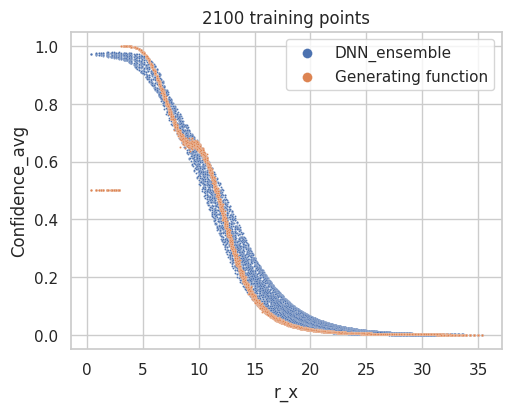

In [43]:
fig, ax = plt.subplots(1, ncols=1, figsize= (5, 4), layout="constrained")
sn.scatterplot(grid_ensembles, x="r_x", y="Confidence_avg", s=2, ax = ax, label ="DNN_ensemble")
sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
ax.set_title(f"{n_data} training points")
ax.legend(markerscale=5)


100%|██████████| 100/100 [00:00<00:00, 600.45it/s]


Text(0.5, 0.98, 'Number of datapoints: 2100')

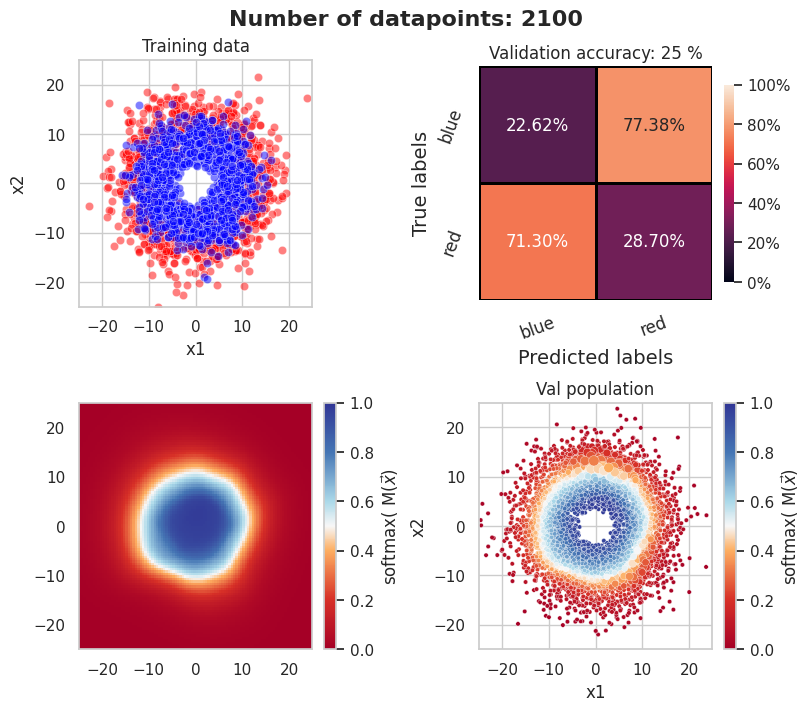

In [49]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
axs[0][0] = plot_data(train_data[0:n_data], axs[0][0], "Training data")
axs[0][1] = plot_conf_matrix(val_data_ensembles, "Truth", "Prediction_ensemble", ["blue", "red"], axs[0][1])
grid_df = predict_grid(model, x1_key, x2_key, device)
axs[1][0] = plot_grid(grid_ensembles, "Confidence_avg", axs[1][0])
axs[1][1] = plot_results(val_data_ensembles, "Confidence_avg", axs[1][1], "Val population", "Confidence_std")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$)', ax=axs[1][1])

#fig.colorbar(axs[1][0], ax=axs[1][0])
#axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
#axs[1][2] = plot_error(df[df["Truth"] == "blue"], axs[1][2])

fig.suptitle(f"Number of datapoints: {n_data}", size=16, fontweight="bold")